## Luodaan tarvittavat kirjastot

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier



## Datan lataaminen ja yhdistäminen

Ladataan eläinonnettomuustiedot ja maakuntien pinta-alatiedot. Yhdistetään nämä samaan dataframeen maakuntanimen perusteella.

In [9]:
onnettomuus = pd.read_csv("koeti_riista_tau_001_en.csv", encoding="latin1")
maakunnat = pd.read_csv("maakunnat_pinta_alat.csv", encoding="utf-8")


maakunnat = maakunnat.rename(columns={"namefin": "regionName"})
data = pd.merge(onnettomuus, maakunnat[["regionName", "area"]], on="regionName", how="left")

## Datan puhdistaminen ja uusien ominaisuuksien luominen

Muunnetaan tapahtuma-aika datetime-muotoon ja luodaan siitä uusia ominaisuuksia, kuten viikonpäivä ja kellonaika. Puhdistetaan puuttuvat arvot.

In [10]:
data["eventTime"] = pd.to_datetime(data["eventTime"], utc=True, errors="coerce")
data = data.dropna(subset=["eventTime"])
data["weekday"] = data["eventTime"].dt.weekday
data["hour"] = data["eventTime"].dt.hour

## Luokkien koodaus sekä aineiston valmistelu ja jako testidataan

Käytämme vain kolmea ajallista ominaisuutta eli kuukausi, viikonpäivä ja kellonaika

In [11]:
features = ["month", "weekday", "hour"]

data = data.dropna(subset=features + ["wildlifeSpeciesName"])

le = LabelEncoder()
data["wildlifeSpeciesName"] = le.fit_transform(data["wildlifeSpeciesName"])

X = data[features]
y = data["wildlifeSpeciesName"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)


## Päätöspuuluokittelumallin opettaminen

Rakennetaan DecisionTreeClassifier-malli ja opetetaan se koulutusdatalla.

In [12]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Mallin arviointi, luokitteluraportti ja muuttujien tärkeyden visuaalisointi

Tarkastellaan mallin tarkkuutta luokitteluraportin ja confusion matrixin avulla. Lisäksi visualisoidaan tärkeimmät ominaisuudet.


                 precision    recall  f1-score   support

          Hirvi       0.27      0.05      0.09      2738
     Kuusipeura       0.00      0.00      0.00        27
    Metsäkauris       0.45      0.37      0.40      6754
     Metsäpeura       0.00      0.00      0.00       104
Valkohäntäpeura       0.54      0.74      0.62      9498
      Villisika       0.00      0.00      0.00        62

       accuracy                           0.50     19183
      macro avg       0.21      0.19      0.19     19183
   weighted avg       0.46      0.50      0.46     19183



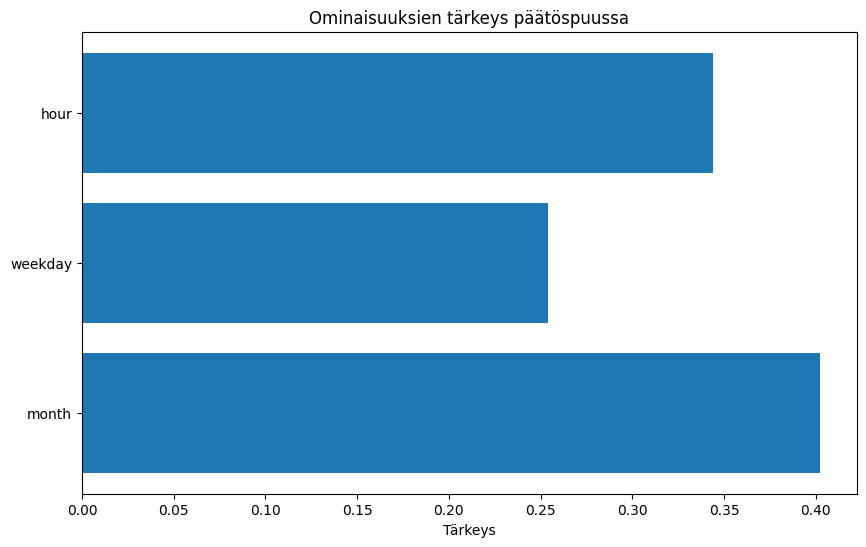

In [13]:
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Tärkeys')
plt.title('Ominaisuuksien tärkeys päätöspuussa')
plt.show()

## Sekamatriisi Random malli tuloksille

Random malli tulokset

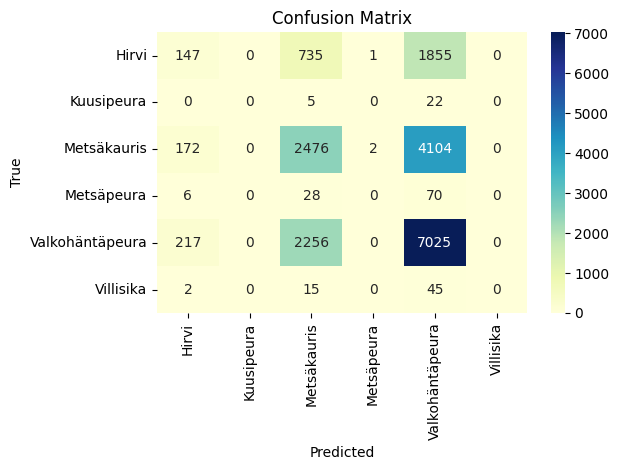

In [14]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
